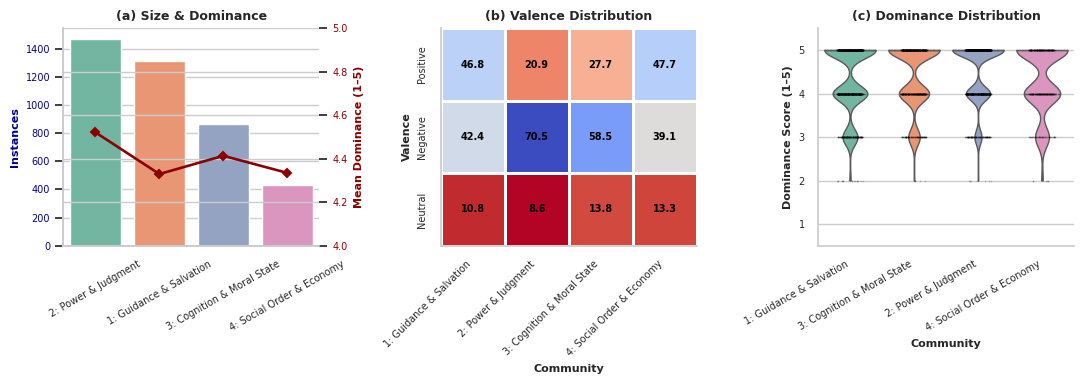

In [ ]:
#@title **Multi-Panel Community Profile Summary**


# --- إعداد عام ---
!git clone https://github.com/NoorBayan/Amthal.git
%cd Amthal

from utility import *
from IPython.display import display, HTML, clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import community as community_louvain
from itertools import combinations
import warnings

# تجاهل التحذيرات الخاصة بالخطوط
warnings.filterwarnings("ignore", message=".*font_manager.*")

# تعيين خط متوفر في كل بيئات matplotlib
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["font.serif"] = ["DejaVu Serif"]

# --- [الخطوة 1: تحميل وتجهيز البيانات] ---
INSTANCES_FILE_PATH = '/content/Amthal/data/processed/instances.csv'
try:
    df = pd.read_csv(INSTANCES_FILE_PATH, sep='\t', encoding='utf-16')
    df['Dominant_Concept']=[Dominant_Concept_dic[i]['en'] for i in df.Dominant_Concept]
    df['Valence']=[Valence_dic[i]['ar'] for i in df.Valence]
    df['Revelation_Phase']=[Revelation_Phase_dic[i]['ar'] for i in df.Revelation_Phase]
    df['Abstraction_Level']=[Abstraction_Level_dic[i]['ar'] for i in df.Abstraction_Level]
    print(f"Data loaded successfully. Found {len(df)} instances.\n")
except FileNotFoundError:
    print(f"⚠️ ERROR: File not found at '{INSTANCES_FILE_PATH}'. Please check the path and try again.")
    exit()

# --- [الخطوة 2: إعداد الأعمدة المشتقة] ---
community_definition = {
    '1: Guidance & Salvation': ['Path', 'Light', 'Shelter', 'Water', 'Life'],
    '2: Power & Judgment': ['Power', 'Ruin', 'Fear', 'Fire', 'Death'],
    '3: Cognition & Moral State': ['Cognition', 'Darkness', 'Emotions', 'Behaviors', 'Trials'],
    '4: Social Order & Economy': [
        'Construction', 'Commerce', 'Transactions',
        'Material Properties', 'Social Relations', 'Purification & Rectification'
    ]
}
concept_to_comm = {c: com for com, concepts in community_definition.items() for c in concepts}
df['Community_Label'] = df['Dominant_Concept'].map(concept_to_comm)
df.dropna(subset=['Community_Label'], inplace=True)

valence_map = {'إيجابي': 'Positive', 'سلبي': 'Negative', 'محايد': 'Neutral'}
if 'Valence' in df.columns:
    df['Valence_En'] = df['Valence'].map(valence_map)

# --- [الخطوة 3: حساب الإحصاءات] ---
community_metrics = df.groupby('Community_Label').agg(
    Instance_Count=('Instance_ID', 'count'),
    Mean_Dominance_Score=('Dominance_Score', 'mean')
).reset_index().sort_values('Instance_Count', ascending=False)

community_valence_table = pd.crosstab(df['Community_Label'], df['Valence_En'])
normalized_valence = community_valence_table.div(community_valence_table.sum(axis=1), axis=0) * 100
normalized_valence = normalized_valence[['Positive', 'Negative', 'Neutral']]

# --- [الخطوة 4: الرسم المتعدد اللوحات] ---
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(11, 4))

# ---- (a) حجم المجتمع ومتوسط السيطرة ----
palette = sns.color_palette("Set2", len(community_metrics))
ax1 = axes[0]
sns.barplot(data=community_metrics, x='Community_Label', y='Instance_Count',
            palette=palette, ax=ax1, legend=False)
ax1.set_xlabel('')
ax1.set_ylabel('Instances', fontsize=8, fontweight='bold', color='darkblue')
ax1.tick_params(axis='x', labelrotation=30, labelsize=7)
ax1.tick_params(axis='y', labelsize=7, labelcolor='darkblue')

# Overlay mean dominance
ax2 = ax1.twinx()
sns.pointplot(data=community_metrics, x='Community_Label', y='Mean_Dominance_Score',
              color='darkred', markers='D', scale=0.7, ax=ax2)
ax2.set_ylabel('Mean Dominance (1–5)', fontsize=8, fontweight='bold', color='darkred')
ax2.tick_params(axis='y', labelsize=7, labelcolor='darkred')
ax2.set_ylim(4.0, 5.0)

ax1.set_title('(a) Size & Dominance', fontsize=9, fontweight='bold')

# ---- (b) خريطة الحرارة للقيم ----
ax3 = axes[1]
sns.heatmap(normalized_valence.T, annot=True, fmt=".1f", linewidths=1, linecolor='white',
            cmap='coolwarm_r', cbar=False, ax=ax3,
            annot_kws={"size": 7, "weight": "bold", "color": "black"})
ax3.set_title('(b) Valence Distribution', fontsize=9, fontweight='bold')
ax3.set_xlabel('Community', fontsize=8, fontweight='bold')
ax3.set_ylabel('Valence', fontsize=8, fontweight='bold')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right', fontsize=7)
ax3.set_yticklabels(ax3.get_yticklabels(), fontsize=7)

# ---- (c) توزيع السيطرة ----
ax4 = axes[2]
sns.violinplot(data=df, x='Community_Label', y='Dominance_Score',
               hue='Community_Label', palette='Set2', inner='quartile', cut=0,
               linewidth=1.0, legend=False, ax=ax4)
sns.stripplot(data=df, x='Community_Label', y='Dominance_Score',
              color='black', size=1.2, alpha=0.2, jitter=0.2, ax=ax4)
ax4.set_title('(c) Dominance Distribution', fontsize=9, fontweight='bold')
ax4.set_xlabel('Community', fontsize=8, fontweight='bold')
ax4.set_ylabel('Dominance Score (1–5)', fontsize=8, fontweight='bold')
ax4.set_ylim(0.5, 5.5)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=30, ha='right', fontsize=7)
ax4.tick_params(axis='y', labelsize=7)

sns.despine()
plt.tight_layout()
plt.savefig("Figure_5_MultiPanel.png", dpi=600, bbox_inches='tight')
clear_output()
plt.show()
